In [4]:
import numpy_financial as npf
import pandas as pd
import numpy as np
from IPython.display import display, HTML

In [2]:
def monthly_PI(interest, years, price, yearly_months=12):
    monthly_PI = -1 * npf.pmt(interest/yearly_months, years*yearly_months, price)
    return monthly_PI

In [152]:
# purchase
purchase_price = 600e3
downpayment = 21e3
rehab_cost = 100e3
after_repair_value = 800e3
value_appreciation = 0.03
rent_appreciation = 0.03
opex_inflation = 0.03

# acquisition
yearly_months = 12
acq_yearly_interest = 0.065
mortgage_years = 30
rehab_months = 6
monthly_taxes = 555 # from zillow

# initial rental period
monthly_rent = 4e3
vacancy_frac, repairs_frac, capex_frac = 0.05, 0.05, 0.05

# refinanced rental period 
ref_yearly_interest = 0.065
refinance_months = 9
pre_refi_duration = refinance_months-rehab_months
# ref_value_appreciation = 0.03
# ref_rent_appreciation = 0.03

In [7]:
class Mortgage():
    def __init__(self, yearly_interest, loan_amount, total_years=30):
        self.yearly_interest = yearly_interest
        self.total_years = total_years
        self.loan_amount = loan_amount
        
        # self.yearly_interest /= 100
        self.monthly_interest = self.yearly_interest / 12
        self.num_payments = total_years * 12
        self.monthly_PI = self.monthly_PI()
        self.df = self.amortization_df()
    
    def monthly_PI(self):
        monthly_PI = self.loan_amount * (self.monthly_interest * np.power(1 + self.monthly_interest, self.num_payments)) / (np.power(1 + self.monthly_interest, self.num_payments) - 1)
        return monthly_PI
    
    def amortization_df(self):

        # # Compute monthly payment
        # monthly_payment = principal * (monthly_interest * np.power(1 + monthly_interest, self.num_payments)) / (np.power(1 + monthly_interest, self.num_payments) - 1)
        
        # Create an array for the number of payments
        payment_num = np.arange(1, self.num_payments + 1)

        # Calculate cumulative interest factor
        interest_factor = np.power(1 + self.monthly_interest, payment_num)
        
        # Compute the remaining balance for each payment
        remaining_balance = self.loan_amount * interest_factor - (self.monthly_PI / self.monthly_interest) * (interest_factor - 1)
        
        # Compute the interest for each payment
        interest_payment = remaining_balance * self.monthly_interest
        
        # Subtract to get the principal for each payment
        principal_payment = self.monthly_PI - interest_payment

        # Put these arrays into a DataFrame
        data = {
            'Payment': np.full(self.num_payments, self.monthly_PI),
            'Principal': principal_payment,
            'Interest': interest_payment,
            'Remaining Balance': remaining_balance
        }
        amortization_schedule = pd.DataFrame(data)
        return amortization_schedule

# mort = Mortgage(0.065, 600e3, 30)
# mort.monthly_PI, mort.monthly_interest, mort.num_payments, mort.df

In [14]:
refi.__dict__, acq.price['monthly_PI'], str(acq)

({'time': {'total_months': 9},
  'price': {'monthly_rent': 4000.0,
   'home_value': 800000.0,
   'vacancy_frac': 0.05,
   'repairs_frac': 0.05,
   'capex_frac': 0.05,
   'monthly_PI': 4095.8007922344154,
   'monthly_taxes': 555,
   'monthly_vacancy': 200.0,
   'monthly_repairs': 200.0,
   'monthly_capex': 200.0,
   'loan_fees': 8000.0,
   'mortgage': 648000.0,
   'monthly_OpEx': 1155.0,
   'monthly_expenses': 5250.800792234415,
   'monthly_cashflow': -1250.800792234415,
   'NOI': 34140.00000000001},
  'exponent': {'yearly_interest': 0.065},
  'mort': <__main__.Mortgage at 0x7f86641bddd8>},
 3697.597937433847,
 '\nAcquisition:\nDown Payment: $21000.0\nLoan Amount: $585000.0\nLoan Points/Fees: $6000.0\nLoan Interest Rate: 6.5%\nMonthly P&I: $3697.60')

In [150]:
class Acquisition():
    """ Could inherent a Mortgage object if it could contain several methods """
    def __init__(self, purchase_price, downpayment, yearly_interest, value_appreciation):
        self.time = {}
        self.price = {
            'home_value': purchase_price,
            'downpayment': downpayment,
            'mortgage': np.nan,
            'monthly_PI': np.nan,
            'monthly_taxes': monthly_taxes,
            
        } 
        self.exponent ={
            'yearly_interest': yearly_interest,
            'yearly_val_apprec': value_appreciation
        }
        self.mort = None
        
        self.derive_properties()
        
    def derive_properties(self):
#         super().__init__(self.price['yearly_interest'], 30, self.price['price'])
        self.price['loan_fees'] = 0.01 * self.price['home_value']
        self.price['mortgage'] = self.price['home_value'] - self.price['downpayment'] + self.price['loan_fees']
        self.price['closing'] = self.price['home_value'] * 0.01 

        self.mort = Mortgage(self.exponent['yearly_interest'], self.price['mortgage'])
        self.price['monthly_PI'] = self.mort.monthly_PI

    def __str__(self):
        return (
            '\nAcquisition:\n'
            f"Down Payment: ${self.price['downpayment']}\n"
            f"Loan Amount: ${self.price['mortgage']}\n"
            f"Loan Points/Fees: ${self.price['loan_fees']}\n"
            f"Loan Interest Rate: {self.exponent['yearly_interest']*100}%\n"
            f"Monthly P&I: ${self.price['monthly_PI']:.2f}\n"
            f"Home Value Appreciaion: ${self.exponent['yearly_val_apprec']*100}%"
         )
        
class Rehab():
    def __init__(self, rehab_months, total_cost, monthly_PI, monthly_insurance=0, other_costs = 0):
        self.time = {
            'total_months' : rehab_months
        }
        self.price= {
            'total_cost': total_cost,
            'monthly_insurance': monthly_insurance,
            'other': other_costs,
            'holding_cost': np.nan,
            'monthly_PI': monthly_PI,
            'monthly_taxes': monthly_taxes
        } 
        self.exponent = {
        }

        self.derive_properties()
        
    def derive_properties(self):
        self.price['monthly_rehab'] = self.price['total_cost']*self.time['total_months']/yearly_months
        self.price['holding_cost'] = (self.price['monthly_PI'] + self.price['monthly_taxes']) * self.time['total_months']
        self.price['monthly_total'] = self.price['monthly_rehab'] + self.price['monthly_taxes'] + self.price['monthly_PI']
        
    def __str__(self):
        return (
            '\nRehab:\n'
            f"Holding costs: ${self.price['holding_cost']:.2f}\n"
            f"Monthly P&I: ${self.price['monthly_PI']:.2f}\n"
            f"Rehab time: {self.time['total_months']} months\n"
            f"Monthly taxes: ${self.price['monthly_taxes']}"
        )
    
class PreReFi_Rent():
    """ Could inherent a Mortgage object if """
    def __init__(self, monthly_rent, vacancy_frac, repairs_frac, capex_frac, total_time, 
                monthly_PI, rent_appreciation, opex_inflation):
        self.time = {
            'total_months': total_time
        }
        self.price =  {
            'monthly_rent': monthly_rent,
            'vacancy_frac': vacancy_frac,
            'repairs_frac': repairs_frac,
            'capex_frac': capex_frac,
            'monthly_taxes': monthly_taxes,
            'monthly_PI': monthly_PI
        } 
        self.exponent = {
            'yearly_rent_apprec': rent_appreciation,
            'yearly_opex_inflation': opex_inflation,
            }
        self.derive_properties()
        
    def derive_properties(self):
        self.price['monthly_vacancy'] = self.price['monthly_rent']*self.price['vacancy_frac']
        self.price['monthly_repairs'] = self.price['monthly_rent']*self.price['repairs_frac']
        self.price['monthly_capex'] = self.price['monthly_rent']*self.price['capex_frac']
        self.price['monthly_OpEx'] = self.sum_opex()
        self.price['monthly_expenses'] = self.price['monthly_OpEx'] + self.price['monthly_PI']
        self.price['monthly_cashflow'] = self.price['monthly_rent'] - self.price['monthly_expenses']
        self.price['NOI'] = (self.price['monthly_cashflow'] + self.price['monthly_PI']) * yearly_months  # googled NOI vs cash flow

    def sum_opex(self):
        exp_sum = self.price['monthly_vacancy'] + self.price['monthly_capex'] \
        + self.price['monthly_taxes'] + self.price['monthly_repairs'] #+ self.price['monthly_PI']
        return exp_sum
    
    def __str__(self):
        return (
            '\nInitial Rental Period:\n'
            f"Monthly Income: ${self.price['monthly_rent']}\n"
            f"Monthly Expenses: ${self.price['monthly_expenses']:.2f}\n"
            f"Monthly Cashflow: ${self.price['monthly_cashflow']:.2f}\n"
            f"NOI: ${self.price['NOI']}"
        )

class Refinance():
    """ Could inherent a Mortgage object if """
    def __init__(self, monthly_rent, home_value, vacancy_frac, repairs_frac, capex_frac, refinance_months, yearly_interest, value_appreciation,
                 rent_appreciation, opex_inflation):
        self.time =  {
            'total_months': refinance_months
        }
        self.price =  {
            'monthly_rent': monthly_rent,
            'home_value': home_value,
            'vacancy_frac': vacancy_frac,
            'repairs_frac': repairs_frac,
            'capex_frac': capex_frac,
            'monthly_PI': np.nan,
            'monthly_taxes': monthly_taxes
        } 
        self.exponent = {
            'yearly_interest': yearly_interest, #0#0.065
            'yearly_val_apprec': value_appreciation,
            'yearly_rent_apprec': rent_appreciation,
            'yearly_opex_inflation': opex_inflation,
        }
        self.mort = None
        self.derive_properties()

    def derive_properties(self):
        self.price['monthly_vacancy'] = self.price['monthly_rent']*self.price['vacancy_frac']
        self.price['monthly_repairs'] = self.price['monthly_rent']*self.price['repairs_frac']
        self.price['monthly_capex'] = self.price['monthly_rent']*self.price['capex_frac']
        self.price['loan_fees'] = 0.01 * self.price['home_value']
        self.price['mortgage'] = 0.8 * self.price['home_value'] + self.price['loan_fees']
        
        self.mort = Mortgage(self.exponent['yearly_interest'], self.price['mortgage'])
        self.price['monthly_PI'] = self.mort.monthly_PI
        # self.price['monthly_PI'] = monthly_PI(self.exponent['yearly_interest'], 30, self.price['mortgage'])
        self.price['monthly_OpEx'] = self.sum_opex()
        self.price['monthly_expenses'] = self.price['monthly_OpEx'] + self.price['monthly_PI']
        self.price['monthly_cashflow'] = self.price['monthly_rent'] - self.price['monthly_expenses']
        self.price['NOI'] = (self.price['monthly_cashflow'] + self.price['monthly_PI']) * yearly_months  # googled NOI vs cash flow

    def sum_opex(self):
        exp_sum = self.price['monthly_vacancy'] + self.price['monthly_capex'] \
        + self.price['monthly_taxes'] + self.price['monthly_repairs'] #+ self.price['monthly_PI']
        return exp_sum
    
    def __str__(self):
        return (
            "\nRefinance:\n"
            f"Loan Amount: ${self.price['mortgage']}\n"
            f"Loan Points/Fees: ${self.price['loan_fees']}\n"
            f"Loan Interest Rate: {self.exponent['yearly_interest']*100}%\n"
            f"Monthly P&I: ${self.price['monthly_PI']:.2f}\n"
            f"Home Value Appreciaion: {self.exponent['yearly_apprec']*100}%"
        )

In [153]:
acq = Acquisition(purchase_price, downpayment, acq_yearly_interest, acq_value_appreciation)
rehab = Rehab(rehab_months, rehab_cost, acq.price['monthly_PI'])
pre_refi = PreReFi_Rent(monthly_rent, vacancy_frac, repairs_frac, capex_frac, 
                        pre_refi_duration, acq.price['monthly_PI'], rent_appreciation, opex_inflation)
refi = Refinance(monthly_rent, after_repair_value, vacancy_frac, repairs_frac, capex_frac, refinance_months, ref_yearly_interest, ref_value_appreciation,
                 rent_appreciation, opex_inflation)

In [155]:
acq.exponent

{'yearly_interest': 0.065,
 'yearly_val_apprec': 0.03,
 'yearly_rent_apprec': 0.03}

In [126]:
print(str(acq))
print(str(rehab))
print(str(pre_refi))
print(str(refi))


Acquisition:
Down Payment: $21000.0
Loan Amount: $585000.0
Loan Points/Fees: $6000.0
Loan Interest Rate: 6.5%
Monthly P&I: $3697.60
Home Value Appreciaion: $3.0%

Rehab:
Holding costs: $25515.59
Monthly P&I: $3697.60
Rehab time: 6 months
Monthly taxes: $555

Initial Rental Period:
Monthly Income: $4000.0
Monthly Expenses: $4852.60
Monthly Cashflow: $-852.60
NOI: $34139.99999999999

Refinance:
Loan Amount: $648000.0
Loan Points/Fees: $8000.0
Loan Interest Rate: 6.5%
Monthly P&I: $4095.80
Home Value Appreciaion: 3.0%


In [127]:
cash_required = acq.price['downpayment'] + rehab.price['total_cost'] + acq.price['closing']
cash_outlay = cash_required + rehab.price['holding_cost']
acq_cash_on_cash_roi = pre_refi.price['monthly_cashflow']*yearly_months/cash_required
ref_cash_on_cash_roi = refi.price['monthly_cashflow']*yearly_months/cash_required

pro_forma_cap_rate = pre_refi.price['NOI']/refi.price['mortgage']
purchase_cap_rate = pre_refi.price['NOI']/acq.price['mortgage']

In [156]:
import pandas as pd
import numpy as np

class YearlySummary:
    def __init__(self, acq, rehab, pre_refi, refi, total_years):
        self.acq = acq
        self.rehab = rehab
        self.pre_refi = pre_refi
        self.refi = refi
        self.total_years = total_years
        self.cash_required = self.acq.price['downpayment'] + self.rehab.price['total_cost'] + self.acq.price['closing']
        
        self.rehab_months = self.applicable_months_per_year(self.rehab.time['total_months'], total_years)
        self.rental_months = 12 - self.rehab_months
        self.acq_months = self.applicable_months_per_year(self.refi.time['total_months'], total_years)
        self.refi_months = 12 - self.acq_months
        self.pre_refi_months = self.applicable_months_per_year(self.pre_refi.time['total_months'], total_years) #- self.rehab_months

    def calculate_annual_data(self):
        data = []
        for year in range(0, self.total_years):
            annual_data = {}
            annual_data['Year'] = year
            annual_data['Month'] = year * yearly_months
            annual_data['Renting Months'] = self.rental_months[year]
            annual_data['Total Annual Income'] = self.pre_refi.price['monthly_rent']*(1+self.acq.exponent['yearly_rent_apprec'])**year * annual_data['Renting Months']
            
            annual_data['Operating Expenses'] = self.operating_expenses(year)
            annual_data['Mortgage Payment'] = self.acq.price['monthly_PI'] * self.acq_months[year] + self.refi.price['monthly_PI'] * self.refi_months[year]
            annual_data['Total Annual Expenses'] = annual_data['Operating Expenses'] + annual_data['Mortgage Payment'] + rehab.price['total_cost'] * self.rehab_months[year]/self.rehab.time['total_months']
            
            annual_data['Total Annual Cashflow'] = annual_data['Total Annual Income'] - annual_data['Total Annual Expenses']
            annual_data['Cash on Cash ROI'] = annual_data['Total Annual Cashflow'] / self.cash_required
            annual_data['Property Value'] = self.property_value(year)
            
            annual_data['Loan Balance'] = self.acq.mort.df.iloc[year]['Remaining Balance']  # this is a simplification, in reality you would need to calculate this based on the amortization schedule of the loan
            annual_data['Equity'] = annual_data['Property Value'] - annual_data['Loan Balance']

            if year == 0:
                equity_gain = annual_data['Equity']
            else:
                equity_gain = annual_data['Equity'] - data[year-1]['Equity']
            
            annual_data['Equity Gain'] = equity_gain
            annual_data['Annual Profit'] = annual_data['Equity Gain'] + annual_data['Total Annual Cashflow']
            annual_data['Annualized Total Return'] = (annual_data['Annual Profit'] / self.cash_required)

            data.append(annual_data)

        return data

    def to_dataframe(self):
        data = self.calculate_annual_data()
        columns = data[0].keys()
        df = pd.DataFrame(data, columns=columns)
        df.style.set_table_styles([dict(selector="th",props=[('max-width', '50px')])])
        pretty_df = df.applymap(self.format_with_sig_figs)
        display(pretty_df)

        return df
    
    def applicable_months_per_year(self, total_months, total_years):
        rental_months = []
        for year in range(1, total_years + 1):
            if total_months >= 12:
                rental_months.append(12)
                total_months -= 12
            elif total_months > 0:
                rental_months.append(total_months)
                total_months = 0
            else:
                rental_months.append(0)
        return np.array(rental_months)
    
    def property_value(self, year):
        acq_period_value = (self.acq.price['home_value']*(1+self.acq.exponent['yearly_val_apprec'])**year + self.rehab.price['total_cost'])*self.acq_months[year]/12 
        ref_period_value = self.refi.price['home_value']*(1+self.refi.exponent['yearly_val_apprec'])**year *self.refi_months[year]/12
        return acq_period_value + ref_period_value
    
    def operating_expenses(self, year):
        pre_refi_opex = self.pre_refi.price['monthly_OpEx'] * self.pre_refi_months[year] * (1+self.pre_refi.exponent['yearly_rent_apprec'])**year
        refi_opex = self.refi.price['monthly_OpEx'] * self.refi_months[year] * (1+self.refi.exponent['yearly_rent_apprec'])**year
        return pre_refi_opex + refi_opex

    def format_with_sig_figs(self, x):
        if x == 0:
            return "0"
        else:
            return "{:,.2f}".format(round(x, 2 - int(np.floor(np.log10(abs(x))))))


In [157]:
year_sum.cash_required

127000.0

In [158]:
year_sum = YearlySummary(acq, rehab, pre_refi, refi, 30)
df = year_sum.to_dataframe()

,Year,Month,Renting Months,Total Annual Income,Operating Expenses,Mortgage Payment,Total Annual Expenses,Total Annual Cashflow,Cash on Cash ROI,Property Value,Loan Balance,Equity,Equity Gain,Annual Profit,Annualized Total Return
0,0,0,6.00,"24,000.00","6,930.00","45,600.00","152,000.00","-128,000.00",-1.01,"725,000.00","584,000.00","141,000.00","141,000.00","12,000.00",0.09
1,1.00,12.00,12.00,"49,400.00","13,900.00","49,100.00","63,000.00","-13,600.00",-0.11,"824,000.00","584,000.00","240,000.00","99,500.00","86,000.00",0.68
2,2.00,24.00,12.00,"50,900.00","13,900.00","49,100.00","63,000.00","-12,100.00",-0.10,"849,000.00","583,000.00","265,000.00","25,300.00","13,200.00",0.10
3,3.00,36.00,12.00,"52,500.00","13,900.00","49,100.00","63,000.00","-10,600.00",-0.08,"874,000.00","583,000.00","291,000.00","26,000.00","15,400.00",0.12
4,4.00,48.00,12.00,"54,000.00","13,900.00","49,100.00","63,000.00","-8,990.00",-0.07,"900,000.00","582,000.00","318,000.00","26,800.00","17,800.00",0.14
5,5.00,60.00,12.00,"55,600.00","13,900.00","49,100.00","63,000.00","-7,360.00",-0.06,"927,000.00","582,000.00","346,000.00","27,600.00","20,200.00",0.16
6,6.00,72.00,12.00,"57,300.00","13,900.00","49,100.00","63,000.00","-5,700.00",-0.04,"955,000.00","581,000.00","374,000.00","28,400.00","22,700.00",0.18
7,7.00,84.00,12.00,"59,000.00","13,900.00","49,100.00","63,000.00","-3,980.00",-0.03,"984,000.00","581,000.00","403,000.00","29,200.00","25,200.00",0.20
8,8.00,96.00,12.00,"60,800.00","13,900.00","49,100.00","63,000.00","-2,200.00",-0.02,"1,010,000.00","580,000.00","433,000.00","30,100.00","27,900.00",0.22
9,9.00,108.00,12.00,"62,600.00","13,900.00","49,100.00","63,000.00",-380.00,-0.00,"1,040,000.00","580,000.00","464,000.00","31,000.00","30,600.00",0.24


In [149]:
df

,Year,Month,Renting Months,Total Annual Income,Operating Expenses,Mortgage Payment,Total Annual Expenses,Total Annual Cashflow,Cash on Cash ROI,Property Value,Loan Balance,Equity,Equity Gain,Annual Profit,Annualized Total Return
0,0,0,6,24000.0,6930.0,45565.783814,152495.783814,-128495.783814,-1.011778,7.250000e+05,584471.152063,1.405288e+05,140528.847937,12033.064124,0.094749
1,1,12,12,48000.0,13860.0,49149.609507,63009.609507,-15009.609507,-0.118186,8.240000e+05,583939.439532,2.400606e+05,99531.712530,84522.103024,0.665528
2,2,24,12,48000.0,13860.0,49149.609507,63009.609507,-15009.609507,-0.118186,8.487200e+05,583404.846892,2.653152e+05,25254.592640,10244.983133,0.080669
3,3,36,12,48000.0,13860.0,49149.609507,63009.609507,-15009.609507,-0.118186,8.741816e+05,582867.358542,2.913142e+05,25999.088350,10989.478843,0.086531
4,4,48,12,48000.0,13860.0,49149.609507,63009.609507,-15009.609507,-0.118186,9.004070e+05,582326.958797,3.180801e+05,26765.847745,11756.238239,0.092569
5,5,60,12,48000.0,13860.0,49149.609507,63009.609507,-15009.609507,-0.118186,9.274193e+05,581783.631886,3.456356e+05,27555.538351,12545.928844,0.098787
6,6,72,12,48000.0,13860.0,49149.609507,63009.609507,-15009.609507,-0.118186,9.552418e+05,581237.361955,3.740045e+05,28368.847715,13359.238208,0.105191
7,7,84,12,48000.0,13860.0,49149.609507,63009.609507,-15009.609507,-0.118186,9.838991e+05,580688.133061,4.032110e+05,29206.484010,14196.874503,0.111786
8,8,96,12,48000.0,13860.0,49149.609507,63009.609507,-15009.609507,-0.118186,1.013416e+06,580135.929178,4.332801e+05,30069.176654,15059.567147,0.118579
9,9,108,12,48000.0,13860.0,49149.609507,63009.609507,-15009.609507,-0.118186,1.043819e+06,579580.734190,4.642378e+05,30957.676941,15948.067434,0.125575


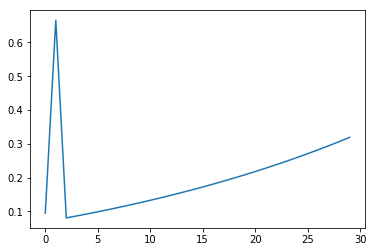

In [142]:
df['Annualized Total Return'].plot()